Import libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(7) #para obtener los mismos resultados cada vez que se ejecuta el codigo

from tqdm import tqdm_notebook
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

import os

import warnings
warnings.filterwarnings("ignore")

import datetime
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

from datetime import date, timedelta

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,GRU
import keras 
from sklearn.preprocessing import MinMaxScaler

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-12-13 16:55:42.830803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 16:55:42.931698: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-13 16:55:43.470885: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-13 16:55:43.470938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

### Read datasets

In [2]:
df= pd.read_csv(os.path.join('datasets', 'timeseries', 'pal_val.csv'), index_col=0, parse_dates=True)

In [3]:
def read_sensor_data():
    sensor_df = pd.read_csv(os.path.join('datasets', 'sensor','raw_sensor_data.csv'), index_col=0, parse_dates=True)
    sensor_df['total'] = sensor_df['20 30 40 50 65 80 90 100 110 120 130 140 150 160 236'.split()].sum(axis=1)
    sensor_df = sensor_df[sensor_df['total']>0]

    sensor_by_roadway= sensor_df[sensor_df['total']>0].groupby(['date','roadway'])['total'].sum().to_frame()
    sensor_by_roadway=sensor_by_roadway.reset_index(level=1)
    
    r1_series = sensor_by_roadway[sensor_by_roadway['roadway']=='r1'].drop('roadway', axis=1)
    r2_series = sensor_by_roadway[sensor_by_roadway['roadway']=='r2'].drop('roadway', axis=1)

    total_sensor= sensor_df['total'].groupby('date').sum('total').to_frame()

    return r1_series, r2_series, total_sensor

r1_ts, r2_ts, total_ts = read_sensor_data()

In [4]:
df = df.loc[total_ts.index]
df.head()

,n_trips
date,
2021-01-01 10:45:00,18.03200
2021-01-01 11:00:00,20.28700
2021-01-01 11:15:00,25.59175
2021-01-01 11:30:00,30.89650
2021-01-01 11:45:00,36.20125


# Data curation

In [5]:
dataset = df.values
dataset = dataset.astype('float32')

In [6]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
lr= 0.7
n_steps_ahead= 8
n_lags= 7

#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = int(dataset.shape[0]*lr)

In [8]:
def generate_time_series_for_rnn_fn(subflow, prev_hours, T=1):
    X= []
    Y= []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours]
        X.append(mob_values)
        
        next_values = subflow[i+prev_hours:i+T+prev_hours]
        Y.append(next_values)
        
    X= np.array(X)
    X = X.reshape(X.shape[0],prev_hours,1)
    
    Y= np.array(Y)
    Y = Y.reshape(Y.shape[0],T,1)
    
    return X,Y

In [9]:
X, Y= generate_time_series_for_rnn_fn(dataset, n_lags, T= n_steps_ahead)

X_train = X[:n_train_days]
y_train = Y[:n_train_days]

X_test = X[n_train_days:]
y_test = Y[n_train_days:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(828, 7, 1) (828, 8, 1) (341, 7, 1) (341, 8, 1)


# NN composition and training

In [10]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

def crear_modeloFF(n_steps_ahead):
    model = Sequential() 
    model.add(GRU(50, input_shape=(None,1), return_sequences=True))
    model.add(GRU(50, return_sequences=True))
    model.add(Dropout(0.30))
    model.add(GRU(50, return_sequences=True))
    model.add(Dropout(0.30))
    model.add(GRU(50))
    model.add(Dense(n_steps_ahead))
    
    model.compile(loss='mse', optimizer='adam',  metrics=[last_time_step_mse])
    model.summary()
    return model

In [11]:
model = crear_modeloFF(n_steps_ahead)

history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test), batch_size=1, verbose=1)

2022-12-13 16:55:44.147141: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-13 16:55:44.147175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mercurio
2022-12-13 16:55:44.147181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mercurio
2022-12-13 16:55:44.147279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-12-13 16:55:44.147300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-12-13 16:55:44.147305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-12-13 16:55:44.147593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 50)          7950      
                                                                 
 gru_1 (GRU)                 (None, None, 50)          15300     
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 gru_2 (GRU)                 (None, None, 50)          15300     
                                                                 
 dropout_1 (Dropout)         (None, None, 50)          0         
                                                                 
 gru_3 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 8)                 4

# Accuracy results

In [12]:
def mape_fn(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid, y_hat):
    metrics= {}
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}
    for i in range(y_valid.shape[1]):
        mae = mean_absolute_error(y_valid[:,i], y_hat[:,i])
        mse = mean_squared_error(y_valid[:,i], y_hat[:,i])
        rmse= mean_squared_error(y_valid[:,i], y_hat[:,i], squared = False)
        cvrmse =  rmse/np.mean(y_valid[:,i])*100 # it is a percentage
        mape = mape_fn(y_valid[:,i], y_hat[:,i])

        metrics_i = {}
        
        metrics_i['mae']= mae
        metrics_global['mae'].append(mae)
        
        metrics_i['mse']= mse
        metrics_global['mse'].append(mse)
        
        metrics_i['rmse']= rmse
        metrics_global['rmse'].append(rmse)
        
        metrics_i['cvrmse']= cvrmse
        metrics_global['cvrmse'].append(cvrmse)
        
        metrics_i['mape']= mape
        metrics_global['mape'].append(mape)
        
        metrics[i]= metrics_i

    metrics_global['mae']= np.mean(metrics_global['mae'])
    metrics_global['mse']= np.mean(metrics_global['mse'])
    metrics_global['rmse']= np.mean(metrics_global['rmse'])
    metrics_global['cvrmse']= np.mean(metrics_global['cvrmse'])
    metrics_global['mape']= np.mean(metrics_global['mape'])
    
    metrics['global']= metrics_global
    
    return metrics

def compute_metrics_as_dataframe_fn(y_valid, y_hat):
    metrics= []
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}
    for i in range(y_valid.shape[1]):
        mae = mean_absolute_error(y_valid[:,i], y_hat[:,i])
        mse = mean_squared_error(y_valid[:,i], y_hat[:,i])
        rmse= mean_squared_error(y_valid[:,i], y_hat[:,i], squared = False)
        cvrmse =  rmse/np.mean(y_valid[:,i])*100 # it is a percentage
        mape = mape_fn(y_valid[:,i], y_hat[:,i])

        metrics.append((i, mae, mse, rmse, cvrmse, mape))
        
    
    metrics_df = pd.DataFrame.from_records(metrics, columns='T MAE MSE RMSE CVRMSE MAPE'.split())
    metrics_df = metrics_df.set_index('T')
    metrics_df.loc['global']= metrics_df.mean(axis=0)
    
    return metrics_df

In [13]:
y_test_reshaped= np.reshape(y_test,(-1,8))

In [14]:
test_predict = model.predict(X_test)
test_predict_rescaled = scaler.inverse_transform(test_predict)
y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

11/11 [==============================] - 1s 6ms/step


In [15]:
X_test.shape, y_test_rescaled.shape, test_predict_rescaled.shape

((341, 7, 1), (341, 8), (341, 8))

In [16]:
lstm_metrics_df= compute_metrics_as_dataframe_fn(y_test_rescaled, test_predict_rescaled)
lstm_metrics_df

,MAE,MSE,RMSE,CVRMSE,MAPE
T,,,,,
0,9.267395,184.252457,13.573962,19.679023,19.269690
1,11.759735,337.602966,18.373976,26.650724,24.431932
2,19.454828,860.732605,29.338245,42.570752,43.697941
3,27.992737,1876.764648,43.321640,63.060355,66.348338
4,35.833714,3133.323975,55.976101,81.710881,93.204105
5,43.197098,4768.625977,69.055237,101.053083,121.217990
6,50.812145,6972.609375,83.502151,122.526634,159.545219
7,58.703491,8853.699219,94.094101,138.477838,215.812373
global,32.127643,3373.451403,50.904427,74.466161,92.940949


In [17]:
lstm_metrics_df.to_csv(os.path.join('results', 'inter_city_level_gru_open_metrics.csv'))

### Learning curves

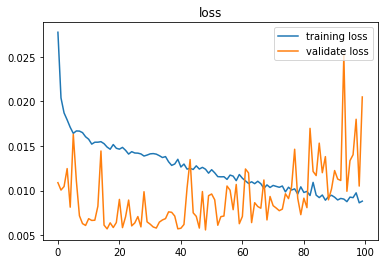

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

## Plot training, test and predicted data

In [19]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

NameError: name 'trainPredict' is not defined